# Stats

In [305]:
options(warn=-1)

In [306]:
library_load <- suppressMessages(
    
    suppressWarnings(
        
        list(
        
            # Seurat 
            library(Seurat), 
                         
            # Data 
            library(tidyverse), 
            library(data.table), 
            library(reactable), 

            # Plotting 
            library(ComplexHeatmap), 
            library(patchwork), 
            library(cowplot), 
            library(ggrepel), 

            # Pyhton compatibility
            library(reticulate), 
            
            # Statistics
            library(emmeans)

        )
    )
)

In [307]:
random_seed <- 42
set.seed(random_seed)

In [308]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO") # You need to adjust this path. I will help. 

In [309]:
# Plotting Theme
source("plotting_global.R")
ggplot2::theme_set(theme_global_set(size_select=1)) # From project global source()

# Load Seurat object

In [310]:
# so <- readRDS("data/BSA_0355_SM01_10x_SPLENO/ANALYSIS/pp.rds")

# FACS  

In [311]:
scale_label <- function(x, y) {
    
    max_y <- max(x[[y]])
    float_y <- attr(regexpr("(?<=\\.)0+", max_y, perl=TRUE), "match.length")
    
    if(max_y>=1) {
    
        x <- x
        ylab="10^6~x~cells/spleen"
        
        return(list(mat=x, ylab=ylab))

    } else if (float_y==-1) {
        
        x[[y]] <- x[[y]]*10
        ylab <- paste0("10^5~x~cells/spleen")

        return(list(mat=x, ylab=ylab)) 
    
    } else {

        exp_scale <- 1+float_y

        x[[y]] <- x[[y]]*10^exp_scale
        ylab <- paste0("10^", 6-exp_scale, "~x~cells/spleen")

        return(list(mat=x, ylab=ylab))

    }
        
}

In [312]:
bar_plot <- function(mat, x, y, xlab="", ylab="", ggtitle="", scale_y=FALSE, parse_y=FALSE) {
    
    if(scale_y) {
        
        res <- scale_label(mat, deparse(substitute(y)))
        mat <- res[[1]]
        ylab <- res[[2]]

    }
    
    p <- ggplot(mat, aes(x={{x}}, y={{y}}, color=genotype, fill=genotype)) + 
    
        geom_bar(stat="summary", position=position_dodge2(), width=0.75, fun=mean, color="black") + 
        geom_jitter(position=position_jitterdodge(dodge.width=0.75), shape=21, stroke=1.0, size=3, show.legend=FALSE, color="black") + 
        xlab(xlab) + ylab(ylab) + ggtitle(ggtitle) + 
        scale_color_manual(values=color$genotype) + 
        scale_fill_manual(values=color$genotype) 
    
    if(parse_y) {
        
        p <- p + ylab(parse(text=ylab))
        
    }
    
    return(p)
    
}

In [313]:
sheet_names <- openxlsx::getSheetNames("data/RG374_ifnar_fl_lysmcre_cpg/facs/spleen//RG374_facs_spleen_data.xlsx")

In [314]:
data <- lapply(sheet_names, function(x) openxlsx::read.xlsx("data/RG374_ifnar_fl_lysmcre_cpg/facs/spleen//RG374_facs_spleen_data.xlsx", sheet=x))
names(data) <- sheet_names

# Sidak test  

In [315]:
sidak <- function(data) {

    data$genotype <- factor(data$genotype, levels=c("WT", "IFNARKO"))
    data$time_point <- factor(data$time_point, levels=c("D0", "D3", "D6"))
    
    # Perform two-way ANOVA
    anova_result <- aov(concentration ~ genotype * time_point, data=data)

    # Post-hoc pairwise comparisons with Sidak correction
    pairwise_comparisons <- emmeans(anova_result, pairwise ~ genotype * time_point, adjust="sidak")
    # pairwise_comparisons <- emmeans(anova_result, pairwise ~ genotype | time_point, adjust="sidak")


    # View the results
    pairwise_comparisons$emmeans  # Estimated marginal means
    pairwise_comparisons$contrasts  # Pairwise comparisons with Sidak adjustment

    # Optional: Display pairwise comparisons in a readable format
    res <- summary(pairwise_comparisons$contrasts) %>% dplyr::mutate(cytokine=data$cytokine[1])
    
    return(res)
    
}

## Flow cytometry 

In [316]:
mat <- data[["absolut"]] %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    dplyr::mutate(genotype=ifelse(genotype=="+/+", "WT", "IFNARKO")) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("WT", "IFNARKO"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "D0", gsub("day", "D", time_point))) %>% dplyr::mutate(time_point=gsub(" ", "", time_point)) %>% 
    dplyr::mutate(time_point=factor(time_point, levels=c("D0", "D3", "D6"))) %>%
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cell_type", value.name=c("count"))

In [317]:
bar_plot_1 <- lapply(split(mat, f=mat$cell_type), function(x) bar_plot(x, time_point, count, scale_y=TRUE, parse_y=TRUE, ggtitle=x$cell_type[1]))

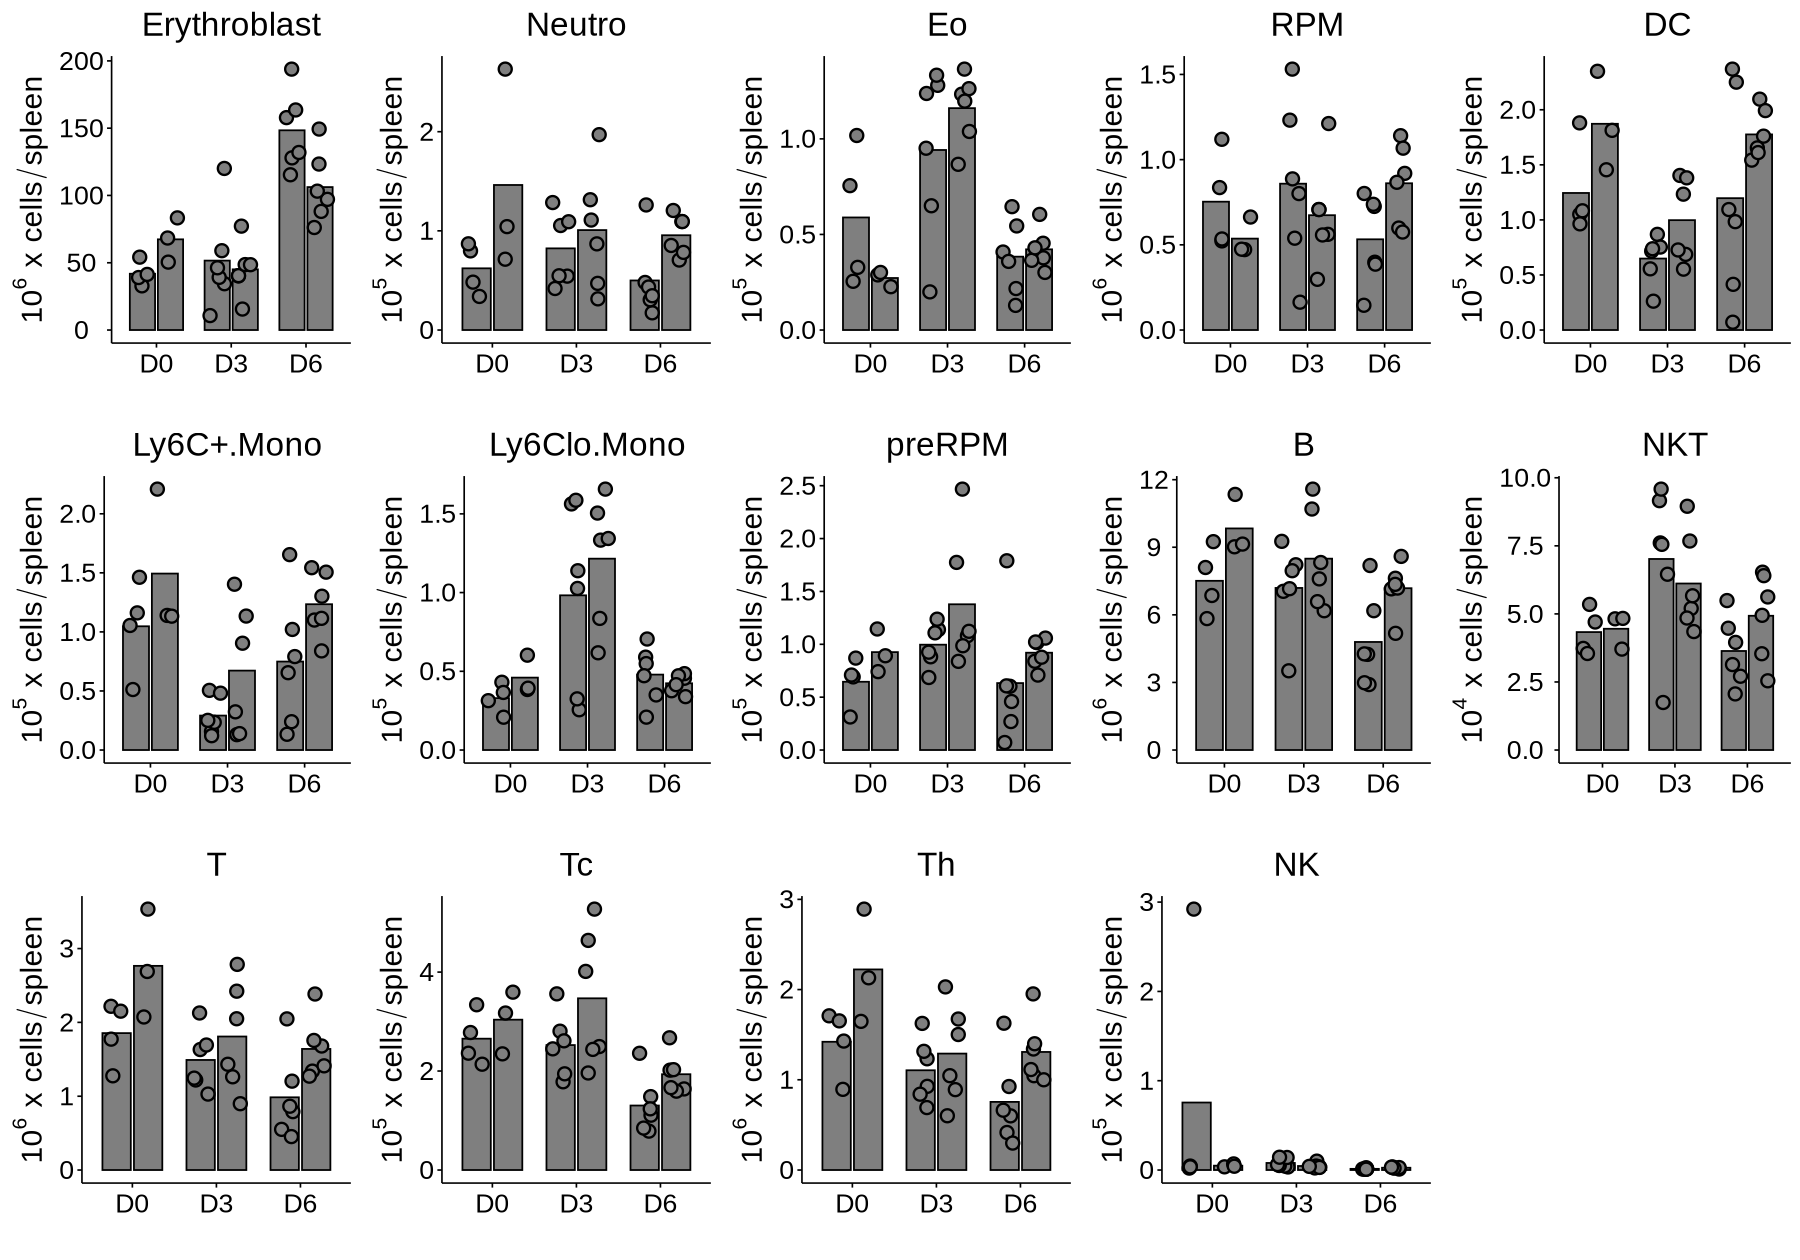

In [318]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")

In [319]:
mat <- mat %>% dplyr::rename(cytokine=cell_type, concentration=count)

In [320]:
stat <- lapply(split(mat, f=mat$cytokine), sidak)
stat <- do.call(rbind, stat)
rownames(stat) <- NULL

In [321]:
contrast_vec <- c(

    "WT D0 - WT D3", "WT D0 - WT D6",
    "IFNARKO D0 - IFNARKO D3", "IFNARKO D0 - IFNARKO D6",
    "WT D0 - IFNARKO D0", "WT D3 - IFNARKO D3", "WT D6 - IFNARKO D6"

    
)

In [322]:
stat <- stat[stat$contrast %in% contrast_vec, ]

In [323]:
stat[stat$p.value <= 0.05, ]

,contrast,estimate,SE,df,t.ratio,p.value,cytokine
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,WT D0 - WT D6,-106.59705915,16.97698966,25,-6.278914,2.151534e-05,Erythroblast
37,IFNARKO D0 - IFNARKO D3,-0.08886517,0.01891092,25,-4.699145,1.218252e-03,Eo


In [324]:
write.csv(stat, "result/RG374_ifnar_fl_lysmcre_cpg/fc_spleen.csv")

## Legendplex (Plasma)

In [325]:
mat <- read.csv("data/RG374_ifnar_fl_lysmcre_cpg/legendplex/plasma/RG374_ifnar_fl_lysmcre_cpg_plasma_legendplex_data_2024_08_23.csv") %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    rename_with(~gsub(".", "-", ., fixed=TRUE)) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cytokine", value.name=c("concentration")) %>% 
    dplyr::mutate(genotype=ifelse(genotype=="+/+", "WT", "IFNARKO")) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("WT", "IFNARKO"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "B", ifelse(time_point=="day3", "D3", "D6")))

In [326]:
bar_plot_1 <- lapply(split(mat, f=mat$cytokine), function(x) bar_plot(x, time_point, concentration, ylab="pg/ml", scale_y=FALSE, parse_y=FALSE, ggtitle=x$cytokine[1]))

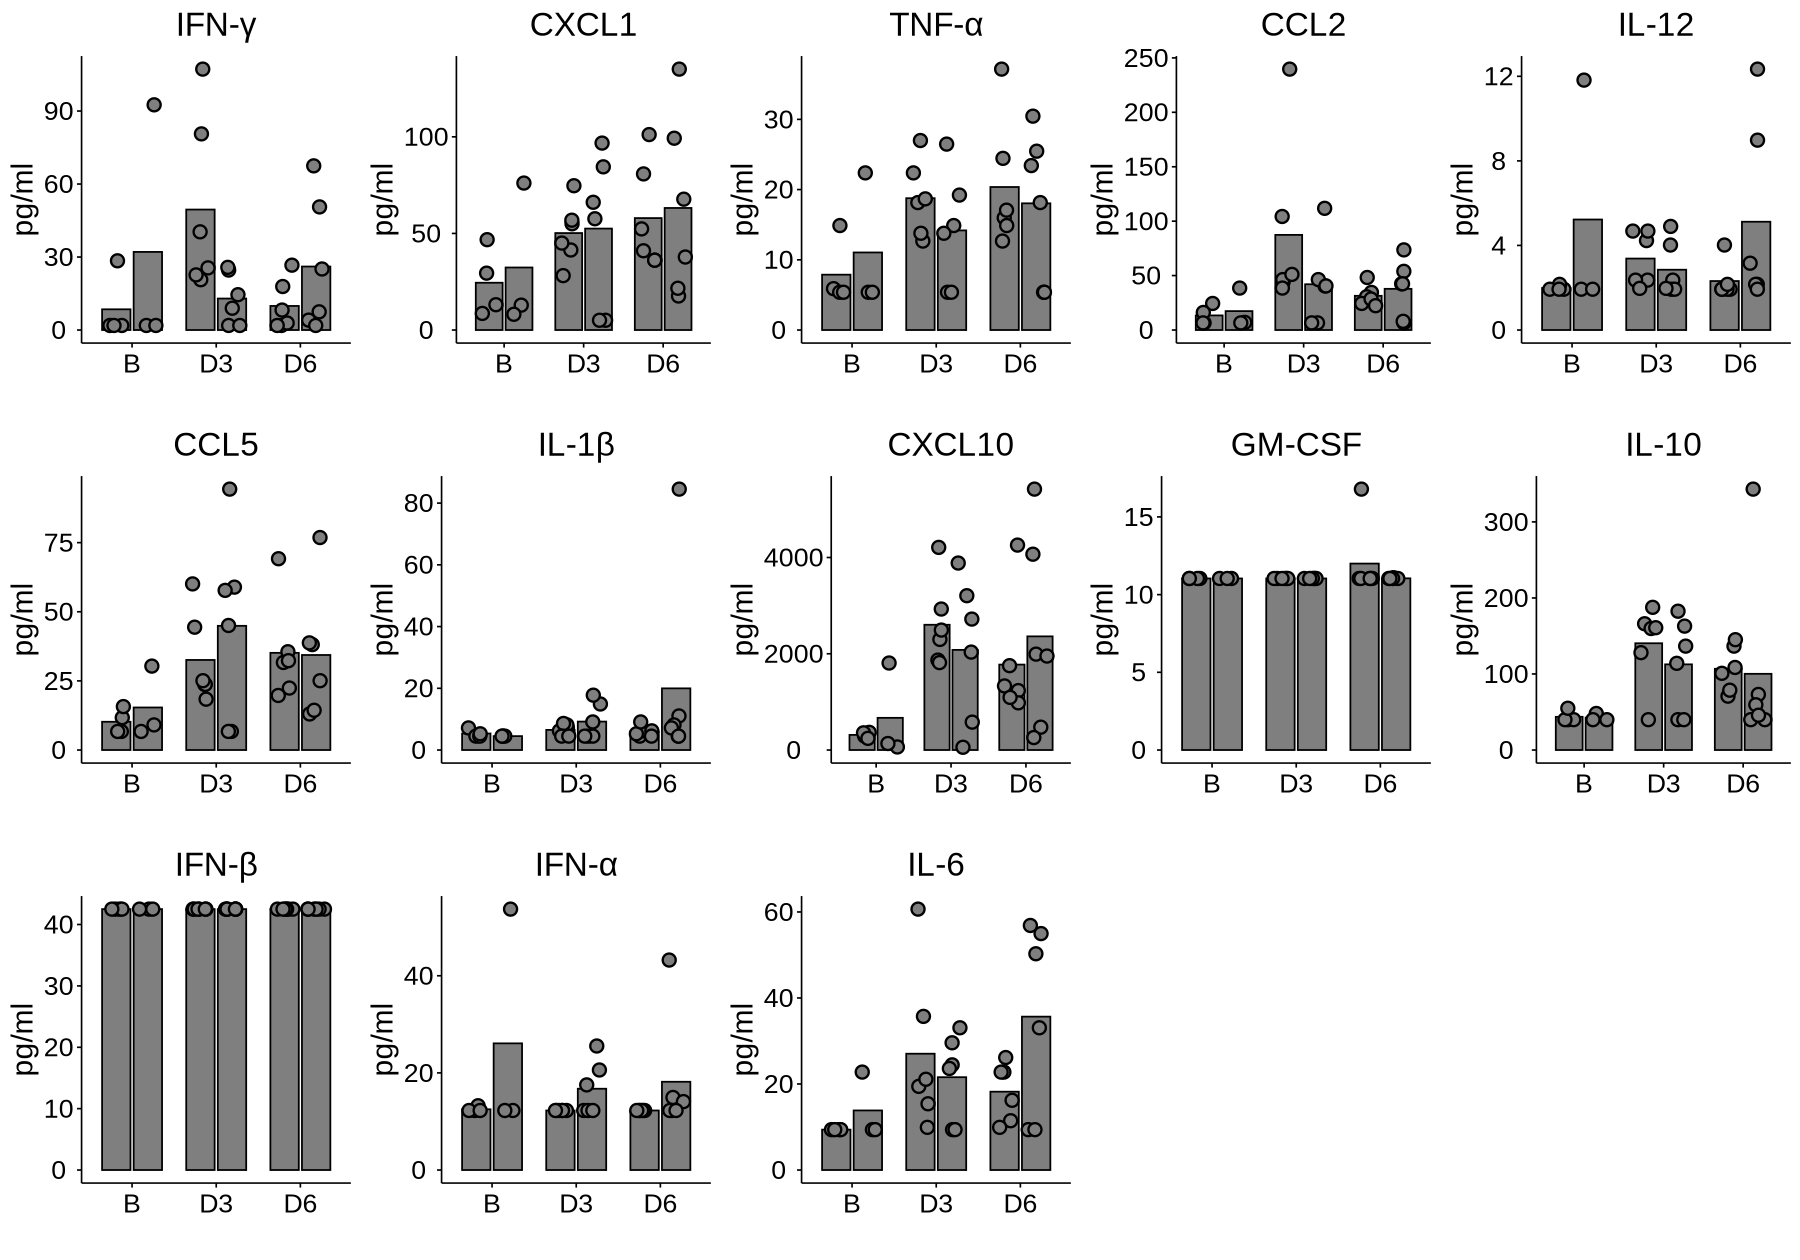

In [327]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")

In [328]:
stat <- lapply(split(mat, f=mat$cytokine), sidak)
stat <- do.call(rbind, stat)
rownames(stat) <- NULL

In [329]:
contrast_vec <- c(

    "WT D0 - WT D3", "WT D0 - WT D6",
    "IFNARKO D0 - IFNARKO D3", "IFNARKO D0 - IFNARKO D6",
    "WT D0 - IFNARKO D0", "WT D3 - IFNARKO D3", "WT D6 - IFNARKO D6"

    
)

In [330]:
stat <- stat[stat$contrast %in% contrast_vec, ]

In [331]:
write.csv(stat, "result/RG374_ifnar_fl_lysmcre_cpg/legendplex_plasma.csv")

In [332]:
stat[stat$p.value <= 0.05, ]

contrast,estimate,SE,df,t.ratio,p.value,cytokine
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>


## Legendplex (Spleen)

In [333]:
mat <- read.csv("data/RG374_ifnar_fl_lysmcre_cpg/legendplex/spleen/RG374_ifnar_fl_lysmcre_cpg_spleen_legendplex_data_2024_08_23.csv") %>% 
    dplyr::select(-Mutation.1, -Grad.1, -Mutation.2, -sample) %>% 
    dplyr::rename(genotype=Grad.2, time_point=well) %>% 
    rename_with(~gsub(".", "-", ., fixed=TRUE)) %>% 
    reshape2::melt(., id.vars=c("genotype", "time_point"), variable="cytokine", value.name=c("concentration")) %>% 
    dplyr::mutate(genotype=ifelse(genotype=="+/+", "WT", "IFNARKO")) %>% 
    dplyr::mutate(genotype=factor(genotype, levels=c("WT", "IFNARKO"))) %>% 
    dplyr::mutate(time_point=ifelse(time_point=="baseline", "B", ifelse(time_point=="day3", "D3", "D6")))

In [334]:
bar_plot_1 <- lapply(split(mat, f=mat$cytokine), function(x) bar_plot(x, time_point, concentration, ylab="pg/ml", scale_y=FALSE, parse_y=FALSE, ggtitle=x$cytokine[1]))

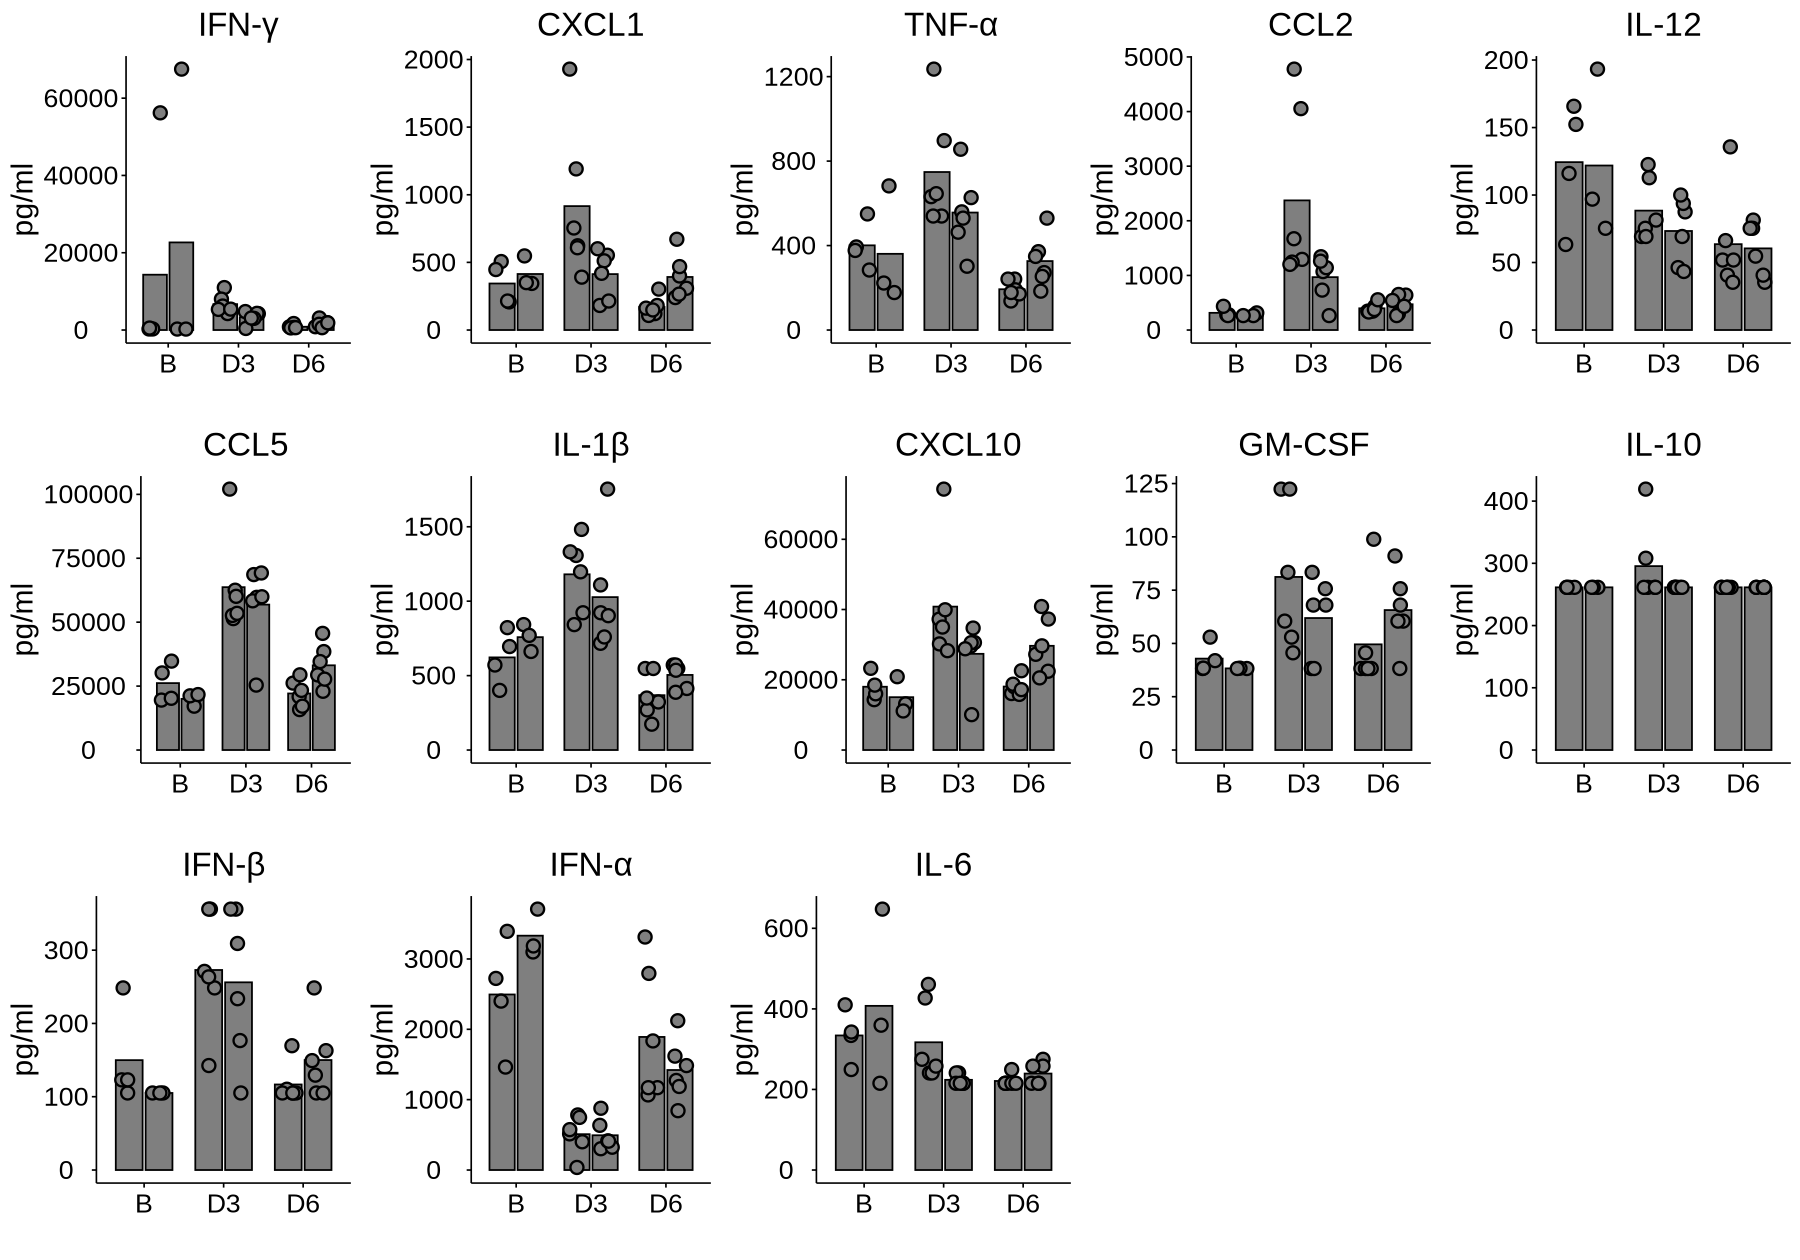

In [335]:
options(repr.plot.width=5*3, repr.plot.height=3*3.5)

ggpubr::ggarrange(plotlist=bar_plot_1, ncol=5, nrow=3, common.legend=TRUE, legend="bottom")

In [345]:
stat <- lapply(split(mat, f=mat$cytokine), sidak)
stat <- do.call(rbind, stat)
rownames(stat) <- NULL

In [347]:
table(stat$contrast)


IFNARKO D3 - IFNARKO D6      IFNARKO D3 - WT D6      WT D3 - IFNARKO D3 
                     13                      13                      13 
     WT D3 - IFNARKO D6           WT D3 - WT D6      WT D6 - IFNARKO D6 
                     13                      13                      13 

In [342]:
contrast_vec <- c(

    "WT D0 - WT D3", "WT D0 - WT D6",
    "IFNARKO D0 - IFNARKO D3", "IFNARKO D0 - IFNARKO D6",
    "WT D0 - IFNARKO D0", "WT D3 - IFNARKO D3", "WT D6 - IFNARKO D6"

    
)

In [343]:
all(contrast_vec %in% stat$contrast)

[1] FALSE

In [344]:
contrast_vec[!contrast_vec %in% stat$contrast]

[1] "WT D0 - WT D3"           "WT D0 - WT D6"          
[3] "IFNARKO D0 - IFNARKO D3" "IFNARKO D0 - IFNARKO D6"
[5] "WT D0 - IFNARKO D0"

In [338]:
stat <- stat[stat$contrast %in% contrast_vec, ]

In [339]:
stat[stat$p.value <= 0.05, ]

,contrast,estimate,SE,df,t.ratio,p.value,cytokine
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,WT D3 - IFNARKO D3,3389.840,887.57199,20,3.819228,0.006422352,IFN-γ
19,WT D3 - IFNARKO D3,1405.387,481.32303,20,2.919841,0.049756599,CCL2
73,WT D3 - IFNARKO D3,93.200,30.31395,20,3.074492,0.035351970,IL-6


In [340]:
write.csv(stat, "result/RG374_ifnar_fl_lysmcre_cpg/legendplex_spleen.csv")